<a href="https://colab.research.google.com/github/diogoalmeida1991/Onibus_2.0/blob/main/%C3%B4nibus_vers%C3%A3o_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pdfplumber
import pdfplumber as pb
from PIL import Image, ImageDraw, ImageFont
import requests
import re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.4 MB/s eta 0:00:00


In [2]:
class Horario():
  def __init__(self, horario):
    #Vetores de horários
    self.horario = horario
    self.janela = self.to_int()
    self.inanicao = 0
    self.sobreposicao = 0
    self.tolerancia = 0
    self.distancia = 0
    self.vetor_inanicao = []
    self.vetor_sobreposicao = []

  def to_int(self):
    int_min = []
    for line in self.horario:
      horas, minutos = map(int, line.split(":"))
      total_minutos = horas * 60 + minutos
      int_min.append(total_minutos)
    return int_min

  def __to_bool_inanicao(self):
    if(len(self.janela)==0 or self.tolerancia==0):
      print("Janela de horários vazia e/ou sem tolerancia aplicada")
      return
    vetor_binario = [False] * 1440
    inicio = True
    for i in range(0,len(self.janela),1):
      if inicio:
        diferenca = self.janela[i+1] - self.janela[i]
        if(diferenca<0):
          for j in range(self.janela[i],1440,1):
            vetor_binario[j] = True
          for j in range(0,self.janela[i+1],1):
            vetor_binario[j] = True
        else:
          for j in range(0,diferenca,1):
            vetor_binario[self.janela[i]+j] = True
        inicio = False
      else:
        inicio = True
    self.inanicao= vetor_binario.count(False)
    self.vetor_inanicao = vetor_binario

  def __to_bool_sobreposicao(self):
    if(len(self.janela)==0 or self.tolerancia==0):
      print("Janela de horários vazia e/ou sem tolerancia aplicada")
      return
    vetor_binario = [False] * 1440
    for i in range(0,len(self.janela)-3,2):
      if(self.janela[i+1]>self.janela[i+2]):
        for j in range(self.janela[i+2],self.janela[i+1],1):
            vetor_binario[j] = True
      elif(self.janela[i]>self.janela[i+3] and self.janela[i+1]<self.janela[i+3]):
        print(f"1 - {self.janela[i]}")
        if(self.janela[i+1]<self.janela[i+2]):
          print(f"2 - {self.janela[i]}")
          for j in range(self.janela[i+2],len(self.janela),1):
              vetor_binario[j] = True
          for j in range(0,self.janela[i+1],1):
              vetor_binario[j] = True
    self.vetor_sobreposicao = vetor_binario
    self.sobreposicao = vetor_binario.count(True)

  def insere_parametros(self, tol=0, dist=0, dir=0):
    self.tolerancia = tol
    self.distancia = dist
    int_horario = self.to_int()
    vetor_tolerancia = []
    novo_horario = []

    for tempo in int_horario:
      novo_horario.append(tempo + self.distancia)
    self.janela = novo_horario
    if (tol!=0):
      for horario in novo_horario:
        if(dir==0):
          if(horario - self.tolerancia<0): #Deu um horário negativo
            vetor_tolerancia.append((horario - self.tolerancia) + 1440)
          else:
            vetor_tolerancia.append(horario - self.tolerancia)
          if(horario + self.tolerancia>1440): #Estorou meia noite
            vetor_tolerancia.append((horario + self.tolerancia) - 1440)
          else:
            vetor_tolerancia.append(horario + self.tolerancia)
        elif(dir==1):
          if(horario - self.tolerancia<0):
            vetor_tolerancia.append((horario - self.tolerancia) + 1440)
          else:
            vetor_tolerancia.append(horario - self.tolerancia)
          vetor_tolerancia.append(horario)
        elif(dir==2):
          vetor_tolerancia.append(horario)
          if(horario + self.tolerancia>1440):
            vetor_tolerancia.append((horario + self.tolerancia) - 1440)
          else:
            vetor_tolerancia.append(horario + self.tolerancia)
      self.janela = vetor_tolerancia
      self.__to_bool_inanicao()
      self.__to_bool_sobreposicao()



In [3]:
class Coleta_horario():
  def __init__(self, url, tipo=0):
    self.__baixar_pdf(url)
    self.horario_bruto = self.__abrir_1pg_linhas()
    self.tipo = tipo
    if(tipo==1):
      self.grade = self.__tipo1()
    elif(tipo==0):
      self.grade = []
      print("Execute a extração manual. Crie um vetor com as linhas anomalas e um matriz com as colunas! A quantidade de linhas deve ser igual no vetor e na matriz.")

  def __baixar_pdf(self, url):
    response = requests.get(url)
    # Verificando se o download foi bem-sucedido
    if response.status_code == 200:
      # Abrindo um arquivo para salvar o PDF
      with open("temp.pdf", "wb") as f:
        f.write(response.content)
      print("PDF baixado com sucesso!")
    else:
      print(f"Falha ao baixar o PDF. Status code: {response.status_code}")

  def __abrir_1pg_linhas(self):
    with pb.open("/content/temp.pdf") as pdf:
      pagina = pdf.pages[0]
      texto_pagina = pagina.extract_text()
      texto_pagina = texto_pagina.splitlines()
      return(texto_pagina)

  #Coleta cada linha do texto bruto e faz uma matriz bidimensional com os horários
  #daquela linha do texto.
  def __coleta_horario_colunas(self):
    horarios_linha = []
    max = 0
    for line in self.horario_bruto:
      horarios = re.findall(r"\d{2}:\d{2}",line)
      if (horarios!=[]):
        if(len(horarios)>max):
          max = len(horarios)
        horarios_linha.append(horarios)
    return horarios_linha

  #tipo1:
  #Quando a linha de ônibus é 2 viagens, tendo sábado e domingo, e ocorre quando
  #o indice par é superior ao impar. Usa o padrão da AVSJ.
  def __tipo1(self):
    horario = [0,0,0,0,0,0]
    grade_horario = [0,0,0,0,0,0]
    horarios = self.__coleta_horario_colunas()
    for i in range(0,6):
      horario[i] = []
    for line in horarios:
      if(len(line)==5):
        for i in range(0,4):
          horario[i].append(line[i])
        horario[5].append(line[4])
      elif(len(line)==3):
        for i in range(0,2):
          horario[i].append(line[i])
        horario[3].append(line[2])
      elif(len(line)==1):
        horario[1].append(line[0])
      else:
        for i in range(0,len(line)):
          horario[i].append(line[i])
    for i in range(0,6):
      grade_horario[i] = Horario(horario[i])
    return grade_horario

  #colunas(inteiro): Quantas colunas o horário tem.
  #linhas(vetor de inteiros): As linhas do horário com anomalias, contagem começa em 1
  #parametros(matriz de inteiros): Os parametros são as colunas das linhas anomalas, contagem começa em 1
  def extracao_manual_avsj(self, colunas, linhas, parametros):
    if len(linhas)!=len(parametros):
      print(f"A quantidade de linhas é {len(linhas)}. A quantidade de parametros é {len(parametros)}. A quantidade de linhas e parametros devem ser iguais!")
      return
    for linha in parametros:
      for elemento in linha:
        if(elemento>colunas):
          print(f"O elemento {elemento} excede o número de colunas: {colunas}")
          return

    horarios = self.__coleta_horario_colunas()
    horario = [0] * colunas
    grade_horario = [0] * colunas

    for i in range(0,colunas):
      horario[i] = []
    for i, line in enumerate(horarios):
      if i+1 not in linhas:
        for j in range(0,len(line)):
          horario[j].append(line[j])
      else:
        linha_parametro = linha.index(i+1)
        for j, parametro in enumerate(parametros[linha_parametro]):
          print(f"O parametro é {parametro} e a linha tem {line[j]}")
          horario[parametro-1].append(line[j])
    for i in range(0,colunas):
      grade_horario[i] = Horario(horario[i])
    self.grade = grade_horario

In [16]:
class Grafico_temporal():
  def __init__(self, vetores_binarios):
    if(len(vetores_binarios)==0):
      print("Vetor vazio!")
      return
    for i in range(0,len(vetores_binarios)):
      if len(vetores_binarios[i])!=1440:
        print(f"Vetor {i} não tem 1440 posições!")
        return
    self.horarios = vetores_binarios
    self.inanicao = 0
    self.sobreposicao = 0
    self.abastecido = 0

  def desenha_horarios(self, indice):
    tela_de_pintura = Image.new('RGB', (1440,140), color='white')
    pincel = ImageDraw.Draw(tela_de_pintura)

    for i in range(0,1440,1):
      if(self.horarios[indice][i]):
        pincel.line((i,20,i,120),fill='green')
      else:
        pincel.line((i,20,i,120),fill='red')
      if i % 60 == 0:
        hora = f"{i//60:02d}:00"
        pincel.text((i+2, 0), hora, fill="black")  # escreve acima do gráfico

    display(tela_de_pintura)

  def __calcula_sobreposicao(self):
    tamanho = len(self.horarios)
    vetor_overlapping = []
    numero = 0
    for i in range(0,1440,1):
      for j in range(0,tamanho,1):
        if(self.horarios[j][i]):
          numero += 1
      vetor_overlapping.append(numero)
      numero = 0
    return vetor_overlapping

  def verifica_sobreposicao(self, quantidade=2):
    tela_de_pintura = Image.new('RGB', (1440,140), color='white')
    pincel = ImageDraw.Draw(tela_de_pintura)
    overlapping = self.__calcula_sobreposicao()
    self.inanicao = 0
    self.sobreposicao = 0
    self.abastecido = 0
    for i in range(0,1440,1):
      if(overlapping[i]==0):
        pincel.line((i,20,i,120),fill='red')
        self.inanicao = self.inanicao + 1
      elif(overlapping[i]<quantidade):
        pincel.line((i,20,i,120),fill='green')
        self.abastecido = self.abastecido + 1
      else:
        pincel.line((i,20,i,120),fill='yellow')
        self.sobreposicao = self.sobreposicao + 1
      if i % 60 == 0:
        hora = f"{i//60:02d}:00"
        pincel.text((i, 0), hora, fill="black")  # escreve acima do gráfico

    display(tela_de_pintura)

In [5]:
horario_bb1 = Coleta_horario("https://viacaosaojose.com.br/wp-content/uploads/2026/01/531.pdf",0)
horario_rp = Coleta_horario("https://viacaosaojose.com.br/wp-content/uploads/2026/01/510.pdf",1)

PDF baixado com sucesso!
Execute a extração manual. Crie um vetor com as linhas anomalas e um matriz com as colunas! A quantidade de linhas deve ser igual no vetor e na matriz.
PDF baixado com sucesso!


In [6]:
vetor = [1]
parametros = [[1,2,3,5,6,8,9]]

In [7]:
horario_bb1.extracao_manual_avsj(9, vetor, parametros)

O parametro é 1 e a linha tem 04:50
O parametro é 2 e a linha tem 05:16
O parametro é 3 e a linha tem 05:35
O parametro é 5 e a linha tem 05:10
O parametro é 6 e a linha tem 05:30
O parametro é 8 e a linha tem 05:12
O parametro é 9 e a linha tem 05:30


In [8]:
horario_bb1.horario_bruto

['LINHA: 531 - BAIRRO A BAIRRO - SENTIDO 1',
 'DIAS ÚTEIS SÁBADOS DOMINGOS/FERIADOS',
 'SAÍDAS SAÍDAS SAÍDAS',
 'TC TAP Quis. TC TAP Quis. TC TAP Quis.',
 '04:50 05:16 05:35 *** 05:10 05:30 *** 05:12 05:30',
 '05:15 05:40 06:00 05:35 06:00 06:20 06:00 06:24 06:44',
 '05:32 05:57 06:22 06:00 06:26 06:50 07:20 07:44 08:04',
 '05:53 06:18 06:44 06:30 06:56 07:20 08:40 09:04 09:24',
 '06:05 06:30 06:56 07:00 07:26 07:50 10:00 10:24 10:44',
 '06:16 06:42 07:08 07:30 07:56 08:20 11:20 11:44 12:04',
 '06:27 06:54 07:20 08:00 08:26 08:50 12:40 13:04 13:24',
 '06:38 07:06 07:32 08:30 08:56 09:20 14:00 14:24 14:44',
 '07:00 07:30 07:56 09:00 09:26 09:50 15:20 15:44 16:04',
 '07:24 07:54 08:20 09:30 09:56 10:20 16:40 17:04 17:24',
 '07:48 08:18 08:44 10:00 10:26 10:50 18:00 18:24 18:44',
 '08:12 08:42 09:08 10:30 10:56 11:20 19:20 19:44 20:04',
 '08:36 09:06 09:32 11:00 11:26 11:50 20:40 21:02 21:20',
 '09:00 09:30 09:56 11:30 11:56 12:20 21:48 22:10 22:27',
 '09:24 09:54 10:20 12:00 12:26 12:50 

In [9]:
horario_bb1.grade[0].insere_parametros(10,5)
horario_rp.grade[0].insere_parametros(10,5)

In [10]:
horario_bb1.grade[0].vetor_inanicao
horario_rp.grade[0].vetor_sobreposicao[300:360]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True]

In [11]:
horario_rp.grade[0]

In [17]:
v = [0,0]
v[0] = horario_rp.grade[0].vetor_inanicao
v[1] = horario_bb1.grade[0].vetor_inanicao

In [18]:
grade1 = Grafico_temporal(v)

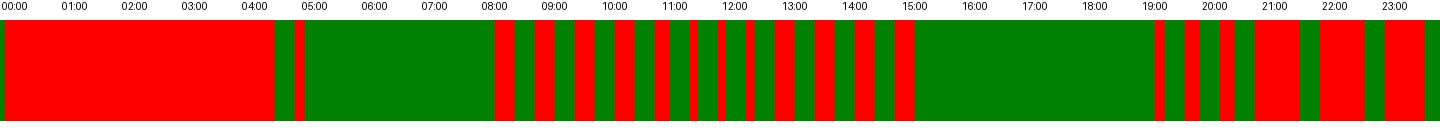

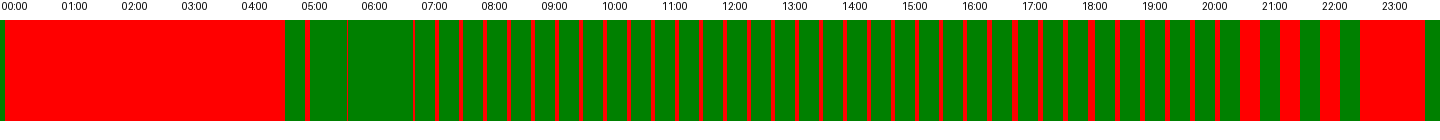

In [19]:
grade1.desenha_horarios(0)
grade1.desenha_horarios(1)

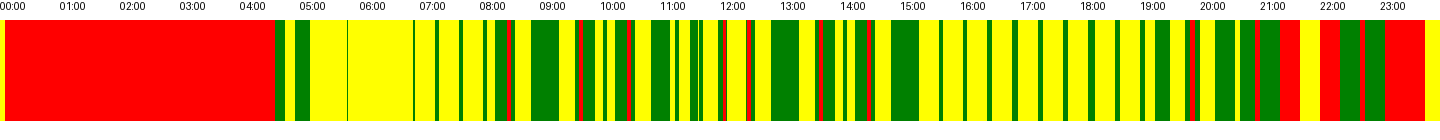

In [20]:
grade1.verifica_sobreposicao()

In [23]:
grade1.inanicao

392